# Entrenamiento y evaluación (Titanic)

Objetivo: entrenar 3 modelos y comparar métricas (accuracy, precision, recall, F1, ROC-AUC) + matrices de confusión.

**Librerías:** pandas/numpy (datos), scikit-learn (pipelines, modelos, métricas), matplotlib (gráficas).

In [1]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Paso 1: Cargar datos

In [2]:

# Espera 'train.csv' del Titanic de Kaggle (ajusta la ruta si es necesario)

df = pd.read_csv("/content/titanic.csv")


y = df['Survived']
X = df.drop(columns=['Survived','SibSp'])
X.head()


,PassengerId,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,3101298,12.2875,NaN,S


### Paso 2: Train/Test split (estratificado)

In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


((334, 10), (84, 10))

### Paso 3: Preprocesamiento (numéricos/categóricos)

In [4]:

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])
len(num_cols), len(cat_cols)


(5, 5)

### Paso 4: Definir 3 modelos

In [5]:

models = {
    "LogReg": LogisticRegression(max_iter=3, n_jobs=None, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=3, max_depth=None, random_state=RANDOM_STATE),
    "GradBoost": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

pipelines = {
    name: Pipeline([("prep", preprocessor), ("clf", model)])
    for name, model in models.items()
}
list(pipelines.keys())


['LogReg', 'RandomForest', 'GradBoost']

In [6]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked
410,1302,3,"Naughton, Miss. Hannah",female,NaN,0,365237,7.7500,NaN,Q
364,1256,1,"Harder, Mrs. George Achilles (Dorothy Annan)",female,25.0,0,11765,55.4417,E50,C
334,1226,3,"Cor, Mr. Ivan",male,27.0,0,349229,7.8958,NaN,S
176,1068,2,"Sincock, Miss. Maude",female,20.0,0,C.A. 33112,36.7500,NaN,S
94,986,1,"Birnbaum, Mr. Jakob",male,25.0,0,13905,26.0000,NaN,C


### Paso 5: Entrenar y evaluar

In [7]:

def safe_pred_proba_or_score(clf, X):
    # Devuelve probas de la clase positiva si existe, si no decision_function escalada a [0,1]
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    elif hasattr(clf, "decision_function"):
        z = clf.decision_function(X)
        # min-max scaling para ROC-AUC si no hay probas
        z_min, z_max = np.min(z), np.max(z)
        if z_max == z_min:
            return np.zeros_like(z, dtype=float)
        return (z - z_min) / (z_max - z_min)
    else:
        # Fallback: usar predicción binaria (menos ideal para AUC)
        return clf.predict(X)

results = []
reports = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_score = safe_pred_proba_or_score(pipe, X_test)

    metrics_row = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_score) if len(np.unique(y_test)) == 2 else np.nan,
    }
    results.append(metrics_row)
    reports[name] = classification_report(y_test, y_pred, zero_division=0)

metrics_df = pd.DataFrame(results).sort_values("f1", ascending=False).reset_index(drop=True)
metrics_df


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg,1.00000,1.000000,1.000000,1.000000,1.000000
1,GradBoost,1.00000,1.000000,1.000000,1.000000,1.000000
2,RandomForest,0.97619,0.967742,0.967742,0.967742,0.994827


### Paso 6: Reporte del mejor modelo

In [10]:

best_name = metrics_df.iloc[0]["model"]
print("Mejor por F1:", best_name)
print("\nClassification report:\n")
print(reports[best_name])


Mejor por F1: LogReg

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



### Paso 7: Matrices de confusión

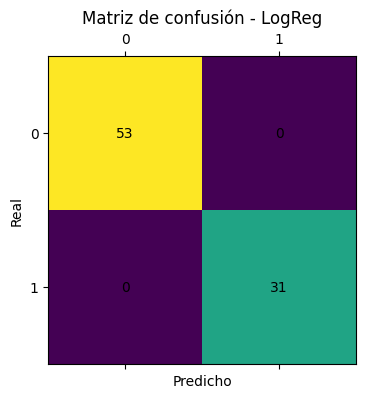

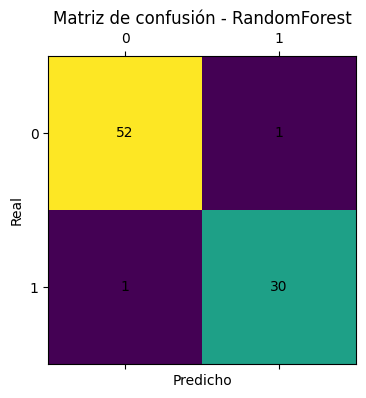

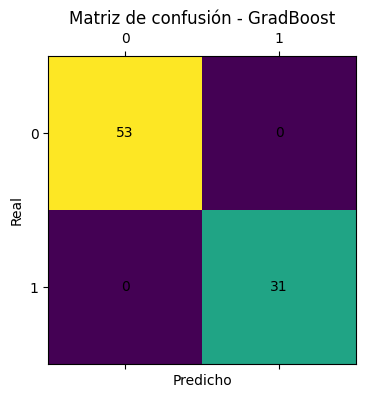

In [11]:

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(cm)
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), va="center", ha="center")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    ax.set_title(f"Matriz de confusión - {name}")
    plt.show()
